# PD 2

### Zuzanna Mróz

## Importy i ładowanie danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder 
from category_encoders import BinaryEncoder
from category_encoders import BaseNEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error

In [2]:
# data = pd.read_csv('https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1')
data = pd.read_csv('allegro-api-transactions.csv')
data.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


## Szybkie sprawdzenie braków

In [3]:
na_ratio_cols = data.isna().mean(axis=0)
na_ratio_cols

lp                        0.0
date                      0.0
item_id                   0.0
categories                0.0
pay_option_on_delivery    0.0
pay_option_transfer       0.0
seller                    0.0
price                     0.0
it_is_allegro_standard    0.0
it_quantity               0.0
it_is_brand_zone          0.0
it_seller_rating          0.0
it_location               0.0
main_category             0.0
dtype: float64

## Target encoding

In [4]:
datatar = data.copy()
datatar.it_location = datatar.it_location.str.lower() # wszystkie litery małe żeby wielkość liter się nie różniła

te = TargetEncoder(data)
datatar['it_location_encoded'] = te.fit_transform(datatar['it_location'], datatar['price'])

datatar.loc[1:10, ['item_id', 'it_location', 'it_location_encoded']]

,item_id,it_location,it_location_encoded
1,4773181874,warszawa,84.132898
2,4781627074,leszno,64.883187
3,4783971474,wola krzysztoporska,35.433365
4,4787908274,białystok,73.772916
5,4790991674,gąbin,21.905209
6,4790991674,gąbin,21.905209
7,4824025074,legionowo,61.505325
8,4826332874,zachodniopomorskie,47.115882
9,4828603874,warszawa,84.132898
10,4834936074,świętochłowice,1.647437


Jak widać wszystko działa. Należe jednak uważać bo to jednak polski zbiór danych i może się zdarzyć, że niektóre lokacje zostały wpisane z polskimi znakami a niektóre nie, przez co będą liczyły się jako osobne miejsca. Np:

In [5]:
lodz = datatar[datatar['it_location'].str.contains('lodz')]
lodz2 = datatar[datatar['it_location'].str.contains('łódź')]
lodz[['it_location','it_location_encoded']].head(1)

,it_location,it_location_encoded
5893,lodz,49.479205


In [6]:
lodz2[['it_location','it_location_encoded']].head(1)

,it_location,it_location_encoded
21,łódź,58.276109


## Trzy inne metody  (one-hot + binary + baseN)

### One hot encoding

In [7]:
data1hot = data.copy()

ohe = OneHotEncoder(sparse=False)
tmp = pd.DataFrame( ohe.fit_transform( data1hot[['main_category']] ) )
tmp.columns = ohe.get_feature_names(['main_category'])
data1hot=pd.concat([data1hot, tmp], axis=1)

data1hot

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,...,main_category_Nieruchomości,"main_category_Odzież, Obuwie, Dodatki",main_category_Przemysł,main_category_RTV i AGD,main_category_Rękodzieło,main_category_Sport i Turystyka,"main_category_Sprzęt estradowy, studyjny i DJ-ski",main_category_Telefony i Akcesoria,main_category_Uroda,main_category_Zdrowie
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,2016-04-03 16:31:01,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,2016-04-03 17:56:11,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,2016-04-03 11:58:55,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,2016-04-03 18:18:37,4826332874,"['RTV i AGD', 'AGD drobne', 'Higiena i pielęgn...",1,1,jupiter2009,12.00,0,49,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,2016-04-03 22:56:56,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Jak widać działa, dodane zostały nowe kolumny wartości z main_category z odpowiadającymi wartościami binarnymi. Jest wada - bardzo zwiększa się wielkość ramki

### Binary encoding

In [8]:
data_bin = data.copy()

be = BinaryEncoder()
tmp = be.fit_transform(data_bin['main_category'])
data_bin = pd.concat([data_bin, tmp], axis=1)

data_bin

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery,0,0,0,0,0,1
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki",0,0,0,0,1,0
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród,0,0,0,0,1,1
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy,0,0,0,1,0,0
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki",0,0,0,0,1,0
5,5,2016-04-03 16:31:01,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki",0,0,0,0,1,0
6,6,2016-04-03 17:56:11,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki",0,0,0,0,1,0
7,7,2016-04-03 11:58:55,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki,0,0,0,1,0,1
8,8,2016-04-03 18:18:37,4826332874,"['RTV i AGD', 'AGD drobne', 'Higiena i pielęgn...",1,1,jupiter2009,12.00,0,49,0,5403,zachodniopomorskie,RTV i AGD,0,0,0,1,1,0
9,9,2016-04-03 22:56:56,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,0,15561,Warszawa,RTV i AGD,0,0,0,1,1,0


Binary encoding jest bardzo podobny do One Hot tylko że zamiast pojedynczej kolumny na każdą kategorię mamy 6 nowych binarnych kategorii, gdzie poszczególne ustawienia zer i jedynek odpowiadają poszczególnej kategorii. Dzięki temu rozmiar ramki nadal się powiększa ale znacznie mniej.

### Base N encoding

In [9]:
database = data.copy()

bne = BaseNEncoder(base=420)
tmp = bne.fit_transform(database['main_category'])
database = pd.concat([database, tmp], axis=1)

database

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,main_category_0,main_category_1
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery,0,1
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki",0,2
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród,0,3
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy,0,4
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki",0,2
5,5,2016-04-03 16:31:01,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki",0,2
6,6,2016-04-03 17:56:11,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki",0,2
7,7,2016-04-03 11:58:55,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki,0,5
8,8,2016-04-03 18:18:37,4826332874,"['RTV i AGD', 'AGD drobne', 'Higiena i pielęgn...",1,1,jupiter2009,12.00,0,49,0,5403,zachodniopomorskie,RTV i AGD,0,6
9,9,2016-04-03 22:56:56,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,0,15561,Warszawa,RTV i AGD,0,6


Tu z kolei znowu mamy binary encoding tylko że z zamianą z base=2 na większą, dzięki czemu zamiast 6 nowych kolumn mamy 2, co prawda z trochę większymi wartościami.

## Braki (Multivariate Feature Imputation)

### Przygotowanie danych

In [10]:
data2 = data.copy()
data2 = data2.loc[:, ['price', 'it_seller_rating', 'it_quantity']]

data2.head()

,price,it_seller_rating,it_quantity
0,59.99,50177,997
1,4.90,12428,9288
2,109.90,7389,895
3,18.50,15006,971
4,19.90,32975,950


###  Imputacja it_seller_rating

In [11]:
RMSE = [] # Root Mean Square Error
imp = IterativeImputer(max_iter=10)

for i in range(10):
    data3 = data2.copy()
    data3.loc[data3.sample(len(data3)//10).index, 'it_seller_rating'] = None # usunięcie losowych 10%
    data3 = pd.DataFrame(imp.fit_transform(data3)) # imputacja

    RMSE.append(np.sqrt(mean_squared_error(data2, data3)))
    
RMSE

[6787.280226162287,
 6718.619598009204,
 6711.56355383265,
 6611.878069797871,
 6661.841560292843,
 6696.562967691094,
 6625.2647830404985,
 6772.230258409912,
 6668.259030259472,
 6804.558965536638]

In [12]:
round(np.std(RMSE)) # odchylenie standardowe

63.0

Jak widać odchylenie standardowe RMSE jest małe, więc wszystko działa. Ogółem te wartości RMSE są jednak dosyć wysokie, więc mimo tego że działa, nie działa najlepiej. Może to być spowodowane tym, że zmienne te nie są skorelowane, jak widać na wykresie poniżej.

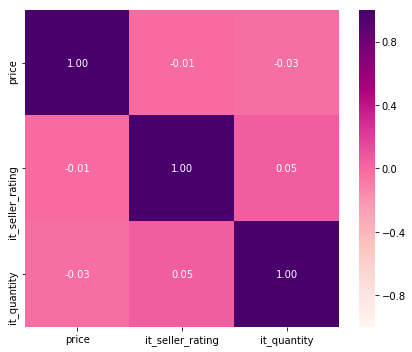

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(data2.corr(), annot=True, fmt=".2f", cmap="RdPu", center=0, vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

###  Imputacja it_seller_rating & it_quantity

In [14]:
RMSE2 = [] # Root Mean Square Error
imp = IterativeImputer(max_iter=10)

for i in range(10):
    data4 = data2.copy()
    data4.loc[data4.sample(len(data4)//10).index, 'it_seller_rating'] = None # usunięcie losowych 10% z seller_rating
    data4.loc[data4.sample(len(data4)//10).index, 'it_quantity'] = None # usunięcie losowych 10% z quantity
    data4 = pd.DataFrame(imp.fit_transform(data4)) # imputacja

    RMSE2.append(np.sqrt(mean_squared_error(data2, data4)))
    
RMSE2

[7910.962909569586,
 7976.158708591089,
 7931.734673948764,
 7882.650892390712,
 7989.949838753412,
 7924.369249966891,
 7943.855446006167,
 7999.780483451563,
 8035.584028369274,
 7861.427361425961]

In [15]:
round(np.std(RMSE2)) # odchylenie standardowe

52.0

Odchylenie standardowe RMSE jest znowu małe, więc wszystko działa. Same wartości RMSE jak widać jednak znacznie się zwiększyły, więc usunięcie większej ilości danych zmniejszyło skuteczność algorytmu, co w sumie nie jest zaskakujące. Poniżej podsumowanie tych wyników na wykresie.

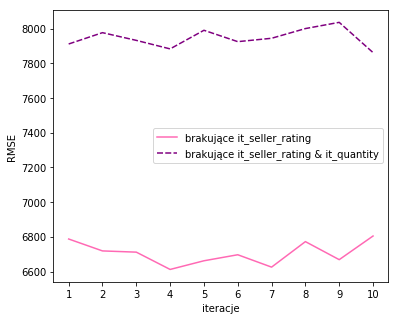

In [16]:
RMSE = pd.DataFrame(RMSE)
RMSE2 = pd.DataFrame(RMSE2)
RMSEs = pd.concat([RMSE, RMSE2], axis=1).reset_index(drop=True)
RMSEs.columns = ['brakujące it_seller_rating', 'brakujące it_seller_rating & it_quantity']
RMSEs.index = [i for i in range(1, 11)]

fig, ax=plt.subplots(figsize=(6,5))
ax.set_ylabel("RMSE")
ax.set_xlabel("iteracje")
ax.set_xticks([i for i in range(1, 11)])
sns.lineplot(data=RMSEs, palette=['hotpink', 'purple']);

(array([0, 1]), <a list of 2 Text xticklabel objects>)

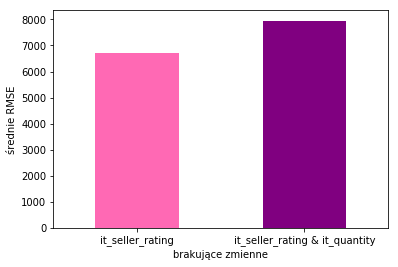

In [17]:
RMSEsMean = pd.concat([RMSE.mean(), RMSE2.mean()])
RMSEsMean.index = ['it_seller_rating', 'it_seller_rating & it_quantity']

RMSEsMean.plot.bar(color=['hotpink', 'purple'])
plt.ylabel("średnie RMSE")
plt.xlabel("brakujące zmienne")
plt.xticks(rotation=0)